# Hydro Tasmania catchment rainfall

In [1]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils
from unseen import indices

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_AGCD-CSIRO_r005_1900-2022_annual_hydro-tas.zarr.zip"
model_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_annual_hydro-tas.zarr.zip"
model_add_bc_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_annual_hydro-tas_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
model_mulc_bc_file = "/g/data/xv83/dbi599/hydrotas/data/Rx14day_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_annual_hydro-tas_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_add_bc_file = "/g/data/xv83/dbi599/hydrotas/data/similarity-test_Rx14day_HadGEM3-GC31-MM-dcppA-hindcast_197011-201811_annual_hydro-tas_bias-corrected-AGCD-CSIRO-additive.zarr.zip"
similarity_mulc_bc_file = "/g/data/xv83/dbi599/hydrotas/data/similarity-test_Rx14day_HadGEM3-GC31-MM-dcppA-hindcast_197011-201811_annual_hydro-tas_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/hydrotas/data/similarity-test_Rx14day_HadGEM3-GC31-MM-dcppA-hindcast_197011-201811_annual_hydro-tas_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/hydrotas/figures/independence-test_Rx14day_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_annual_hydro-tas.png"
model_name = "HadGEM3-GC31-MM"
min_lead = 0
region_name = "hydro-tas"
shape_file = "/home/599/dbi599/hydrotas/shapefiles/hydro-combined.shp"
file_list = (
    "/home/599/dbi599/hydrotas/file_lists/HadGEM3-GC31-MM_dcppA-hindcast_pr_files.txt"
)
nino_file = "/g/data/xv83/dbi599/hydrotas/data/nino34-anomaly_HadGEM3-GC31-MM-dcppA-hindcast_196011-201811_base-197011-201811.nc"


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p model_file [filepath])"
assert os.path.isfile(model_add_bc_file), "Must provide a model additive bias corrected data file (papermill option -p model_add_bc_file [filepath])"
assert os.path.isfile(model_mulc_bc_file), "Must provide a model multiplicative bias corrected data file (papermill option -p model_mulc_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_add_bc_file), "Must provide an additive bias corrected similarity test file (papermill option -p similarity_add_bias_file [filepath])"
assert os.path.isfile(similarity_mulc_bc_file), "Must provide an multiplicative bias corrected similarity test file (papermill option -p similarity_mulc_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
prmax = agcd_ds['pr'].values.max()
print(prmax)

277.08005


In [9]:
ranked_events = agcd_ds.to_dataframe().sort_values(['pr'], ascending=False)

## Model ensemble

### Region selection

In [10]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [11]:
first_file

'/g/data/oi10/replicas/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r1i1p1f2/day/pr/gn/v20200417/pr_day_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_19601101-19601230.nc'

In [12]:
shapes = gp.read_file(shape_file)

In [13]:
isel_dict = {}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [14]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-47, -37],
    lon_bnds=[141, 152],
    shapefile=shape_file,
    shape_overlap=0.05,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

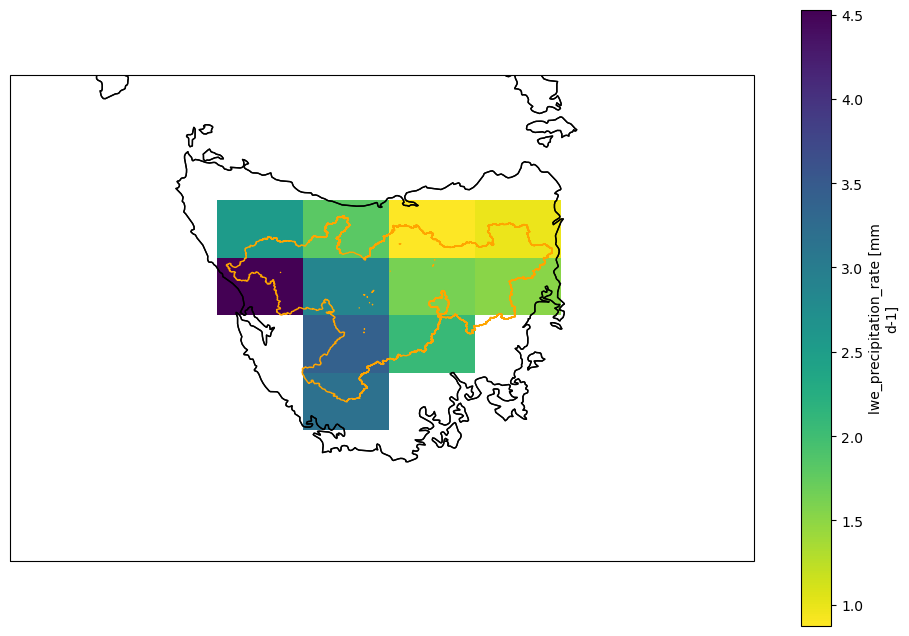

In [15]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].mean('time', keep_attrs=True).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.set_xlim([143, 150.2])
ax.set_ylim([-44.6, -39.9])
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [16]:
model_ds = fileio.open_dataset(model_file)
model_add_bc_ds = fileio.open_dataset(model_add_bc_file)
model_mulc_bc_ds = fileio.open_dataset(model_mulc_bc_file)

In [17]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 10, init_date: 59, lead_time: 12)
Coordinates:
  * ensemble    (ensemble) int64 0 1 2 3 4 5 6 7 8 9
    event_time  (init_date, ensemble, lead_time) <U28 dask.array<chunksize=(59, 10, 12), meta=np.ndarray>
  * init_date   (init_date) object 1960-11-01 00:00:00 ... 2018-11-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10 11
    time        (lead_time, init_date) object dask.array<chunksize=(12, 59), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time) float64 dask.array<chunksize=(1, 1, 12), meta=np.ndarray>
Attributes: (12/43)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            DCPP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    table_info:             Creation Date:(13 December 2018) MD5:f0588f7f55b5...
    title:                  HadGEM3-GC31-MM output prepared for CMIP6
    tracking_id:            hdl:21.14100/3163965c-a593-4abd-9b2a-9ee755aef228
    variable_id:            pr
    variable_name:          pr
    variant_label:          r1i1p1f2

In [18]:
print(min_lead)

0


In [19]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

In [20]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [21]:
model_da_stacked.shape

(5900,)

In [22]:
model_add_bc_da_stacked = model_add_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [23]:
model_add_bc_da_stacked.shape

(5900,)

In [24]:
model_mulc_bc_da_stacked = model_mulc_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [25]:
model_mulc_bc_da_stacked.shape

(5900,)

### Stability testing

In [26]:
def plot_dist_by_lead(sample_ds, model_name):
    """Plot distribution curve by lead time"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    lead_times = np.unique(model_da_stacked['lead_time'].values)
    colors = iter(plt.cm.BuPu(np.linspace(0.3, 1, len(lead_times))))

    for lead in lead_times:
        ds_selection = sample_ds.sel({'lead_time': lead})
        ds_selection = ds_selection.dropna('sample')
        color = next(colors)
        lead_df = pd.DataFrame(ds_selection.values)
        n_values = len(ds_selection)
        sns.kdeplot(lead_df[0], ax=ax, color=color, label=f'lead time {lead} ({n_values} samples)')

    ax.grid(True)
    #ax.set_xlim(26, 46)    
    ax.set_title(f'Rx14day for {region_name} ({model_name})')
    ax.set_xlabel('Rx14day precipitation (mm)')
    ax.legend()
    plt.show()

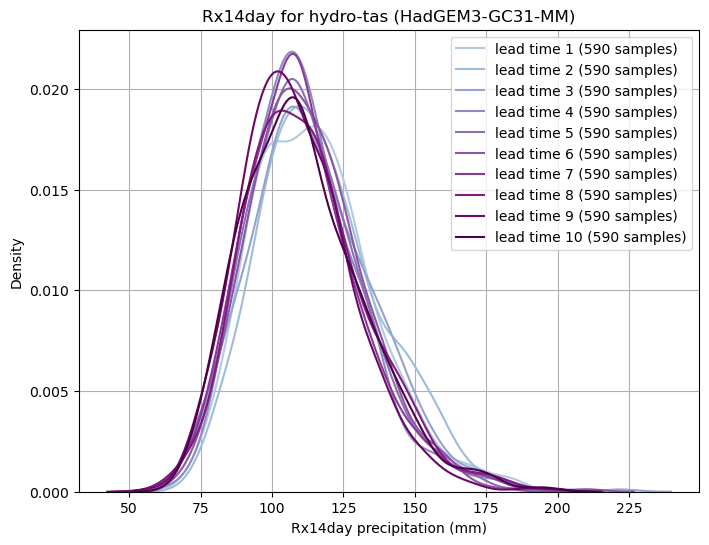

In [27]:
plot_dist_by_lead(model_da_stacked, model_name)

In [28]:
def return_curve(data, method):
    """Return x and y data for a return period curve.
    
    Args:
      data: xarray DataArray
      method : {'gev', 'empirical'}
          Fit a GEV or not to data
    """
    
    if method == 'gev':
        return_periods = np.logspace(0, 4, num=10000)
        probabilities = 1. / return_periods
        shape, loc, scale = indices.fit_gev(data, generate_estimates=True)
        return_values = gev.isf(probabilities, shape, loc, scale)
    elif method == 'empirical':
        return_values = np.sort(data, axis=None)[::-1]
        return_periods = len(data) / np.arange(1.0, len(data) + 1.0)
        
    return return_periods, return_values

In [29]:
def plot_return(sample_ds, model_name, method, outfile=None):
    """Plot single return period curve.
    
    method: {'gev', 'empirical'}  
    """
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    return_periods, return_values = return_curve(sample_ds, method)
    ax.plot(return_periods, return_values)
    ax.set_xscale('log')
    ax.set_title(f'Rx14day for {region_name} ({model_name})')
    ax.set_xlabel('return period (years)')
    ax.set_ylabel('Rx14day precipitation (mm)')
    ax.axhline(prmax, color='0.5', linestyle='--')
    ax.grid()
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [30]:
def plot_return_by_lead(sample_ds, model_name, uncertainty=False):
    """Plot return period curve by lead time"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    lead_times = np.unique(model_da_stacked['lead_time'].values)
    colors = iter(plt.cm.BuPu(np.linspace(0.3, 1, len(lead_times))))

    for lead in lead_times:
        ds_selection = sample_ds.sel({'lead_time': lead})
        ds_selection = ds_selection.dropna('sample')
        return_periods, return_values = return_curve(ds_selection, method='empirical')
        n_values = len(ds_selection)
        label = f'lead time {lead} ({n_values} samples)'
        color = next(colors)
        ax.plot(return_periods, return_values, label=label, color=color)
    
    if uncertainty:
        random_return_values = []
        for i in range(1000):
            random_sample = np.random.choice(sample_ds, n_values)
            return_periods, return_values = return_curve(random_sample, method='empirical')
            random_return_values.append(return_values)
        random_return_values_stacked = np.stack(random_return_values)
        upper_ci = np.percentile(random_return_values_stacked, 97.5, axis=0)
        lower_ci = np.percentile(random_return_values_stacked, 2.5, axis=0)
        ax.fill_between(return_periods, upper_ci, lower_ci, label='95% confidence interval', color='0.5', alpha=0.1)
    
    ax.grid()
    ax.set_xscale('log')
    ax.set_title(f'Rx14day for {region_name} ({model_name})')
    ax.set_xlabel('return period (years)')
    ax.set_ylabel('Rx14day precipitation (mm)')
    ax.legend()
    plt.show()

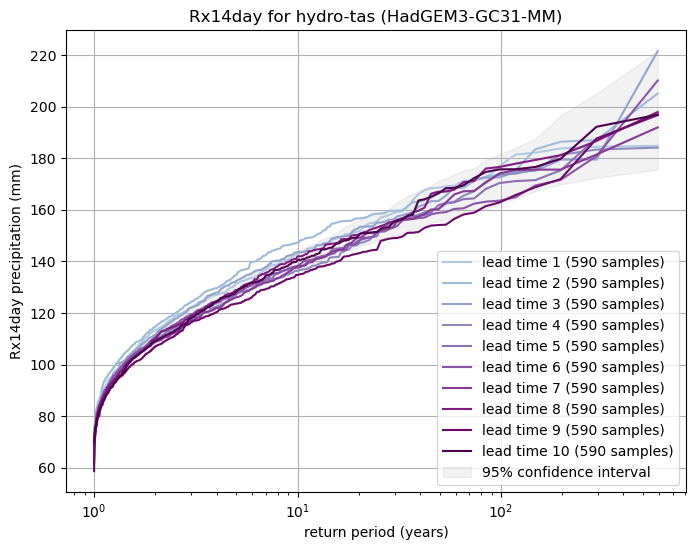

In [31]:
plot_return_by_lead(model_da_stacked, model_name, uncertainty=True)

In [32]:
def plot_dist_by_decade(sample_ds, model_name):
    """Plot distribution curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        color = next(colors)
        decade_df = pd.DataFrame(ds_selection.values)
        n_values = len(ds_selection) 
        sns.kdeplot(decade_df[0], ax=ax, color=color, label=f'{start_year}-{end_year} ({n_values} samples)')

    ax.grid(True)
    #ax.set_xlim(26, 46)    
    ax.set_title(f'Rx14day for {region_name} ({model_name})')
    ax.set_xlabel('Rx14day precipitation (mm)')
    ax.legend()
    plt.show()

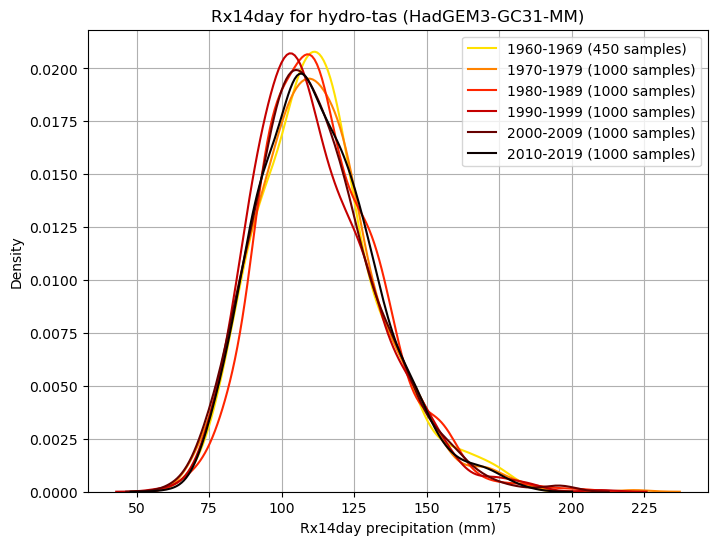

In [33]:
plot_dist_by_decade(model_da_stacked, model_name)

In [34]:
def plot_return_by_decade(sample_ds, model_name, method, uncertainty=False, savefig=False):
    """Plot return period curve by decade.
    
    savefig can be 'raw', 'mulc' or 'add'
    """

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        return_periods, return_values = return_curve(ds_selection, method)
        n_years = len(ds_selection)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(return_periods, return_values, label=label, color=color)
    
    if uncertainty:
        random_return_values = []
        for i in range(1000):
            random_sample = np.random.choice(sample_ds, n_years)
            return_periods, return_values = return_curve(random_sample, method)
            random_return_values.append(return_values)
        random_return_values_stacked = np.stack(random_return_values)
        upper_ci = np.percentile(random_return_values_stacked, 97.5, axis=0)
        lower_ci = np.percentile(random_return_values_stacked, 2.5, axis=0)
        ax.fill_between(return_periods, upper_ci, lower_ci, label='95% confidence interval', color='0.5', alpha=0.2)
    
    ax.grid()
    ax.set_xscale('log')
    ax.set_title(f'Rx14day for {region_name} ({model_name})')
    ax.set_xlabel('return period (years)')
    ax.set_ylabel('Rx14day precipitation (mm)')
    ax.legend()
    ax.axhline(prmax, color='0.5', linestyle='--')
    if savefig:
        outfile = f'/g/data/xv83/dbi599/hydrotas/figures/Rx14day_return_curve_{method}_{region_name}_{model_name}_by-decade_{savefig}.png'
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    plt.show()

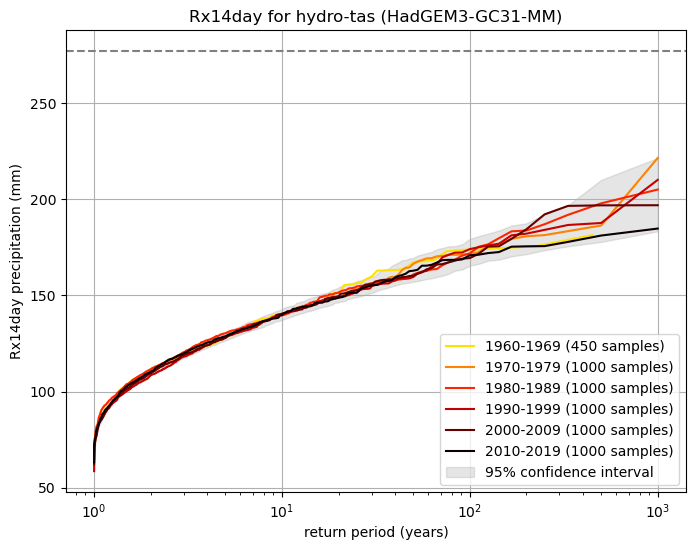

In [35]:
plot_return_by_decade(model_da_stacked, model_name, method='empirical', uncertainty=True)

### Independence testing

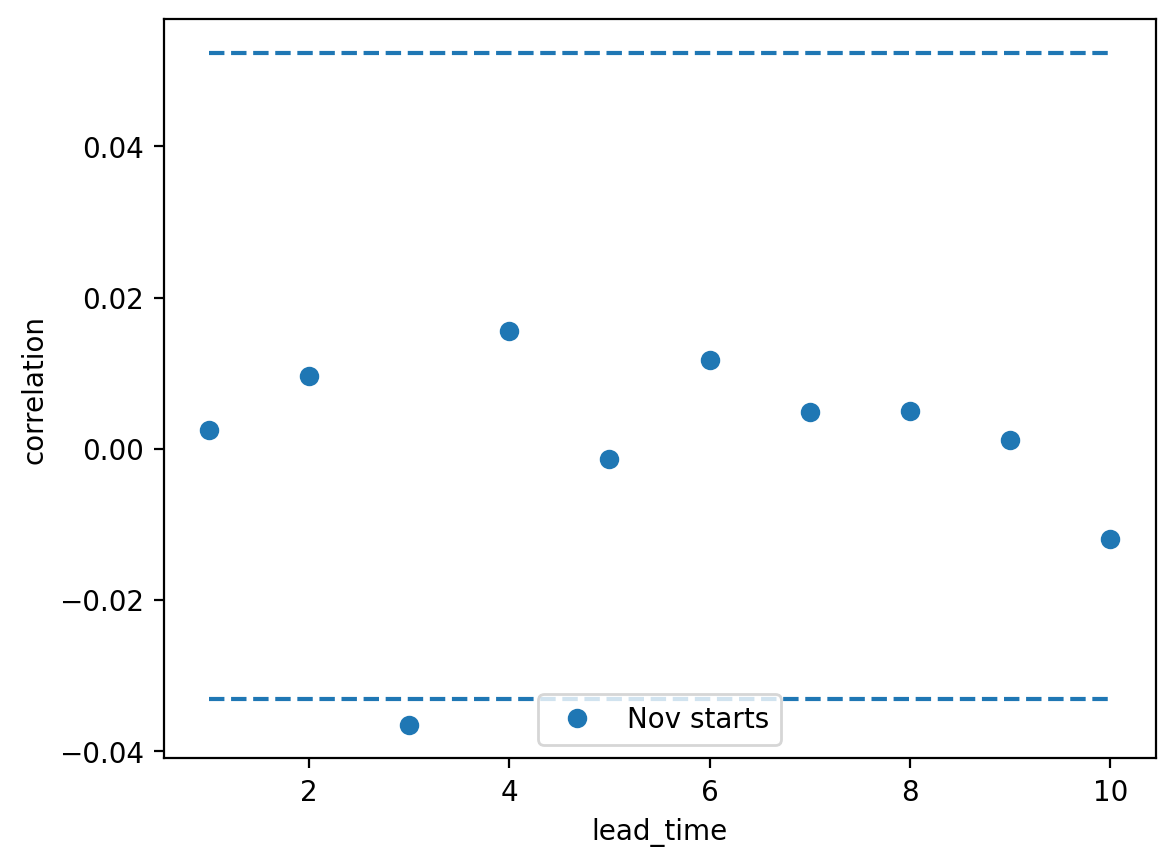

In [36]:
Image(filename=independence_plot)

### Bias correction and fidelity testing

In [37]:
model_gev_shape, model_gev_loc, model_gev_scale = indices.fit_gev(
    model_da_stacked.values,
    generate_estimates=True
)

In [38]:
model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale = indices.fit_gev(
    model_add_bc_da_stacked.values,
    generate_estimates=True
)

In [39]:
model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale = indices.fit_gev(
    model_mulc_bc_da_stacked.values,
    generate_estimates=True
)

In [40]:
agcd_gev_shape, agcd_gev_loc, agcd_gev_scale = indices.fit_gev(
    agcd_ds['pr'].values,
    generate_estimates=True
)

In [41]:
def plot_distributions(include_additive=False, include_multiplicative=False):
    """Plot various distributions"""

    outfile = f'/g/data/xv83/dbi599/hydrotas/figures/Rx14day_histogram_{model_name}_{region_name}'
    
    fig = plt.figure(figsize=[10, 6])
    gev_xvals = np.arange(0, 500)

    model_da.plot.hist(
        bins=50, density=True, label=model_name, alpha=0.7, facecolor='tab:blue',
    )
    model_gev_pdf = gev.pdf(gev_xvals, model_gev_shape, model_gev_loc, model_gev_scale)
    plt.plot(gev_xvals, model_gev_pdf, color='tab:blue', linewidth=4.0)

    if include_additive:
        model_add_bc_ds['pr'].plot.hist(
            bins=50, density=True, label=f'{model_name} additive bias corrected', facecolor='tab:red', alpha=0.7
        )
        model_add_bc_gev_pdf = gev.pdf(gev_xvals, model_add_bc_gev_shape, model_add_bc_gev_loc, model_add_bc_gev_scale)
        plt.plot(gev_xvals, model_add_bc_gev_pdf, color='tab:red', linewidth=4.0)
        outfile = outfile + '_add'
        
    if include_multiplicative:
        model_mulc_bc_ds['pr'].plot.hist(
            bins=50, density=True, label=f'{model_name} multiplicative bias corrected', facecolor='tab:orange', alpha=0.7
        )
        model_mulc_bc_gev_pdf = gev.pdf(gev_xvals, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)
        plt.plot(gev_xvals, model_mulc_bc_gev_pdf, color='tab:orange', linewidth=4.0)
        outfile = outfile + '_mulc'
        
    agcd_ds['pr'].plot.hist(
        bins=50, density=True, label='AGCD', facecolor='tab:gray', alpha=0.7
    )
    agcd_gev_pdf = gev.pdf(gev_xvals, agcd_gev_shape, agcd_gev_loc, agcd_gev_scale)
    plt.plot(gev_xvals, agcd_gev_pdf, color='tab:gray', linewidth=4.0)

    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Rx14day for {region_name} ({model_name})')
    plt.xlim(50, 300)
    plt.legend()
    outfile = outfile + '.png'
    print(outfile)
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    plt.show()

/g/data/xv83/dbi599/hydrotas/figures/Rx14day_histogram_HadGEM3-GC31-MM_hydro-tas.png


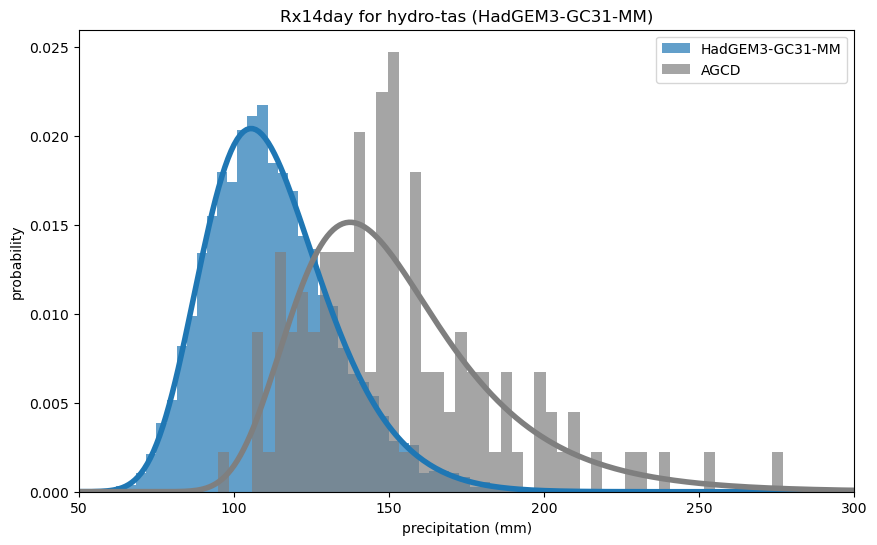

In [42]:
plot_distributions()

/g/data/xv83/dbi599/hydrotas/figures/Rx14day_histogram_HadGEM3-GC31-MM_hydro-tas_mulc.png


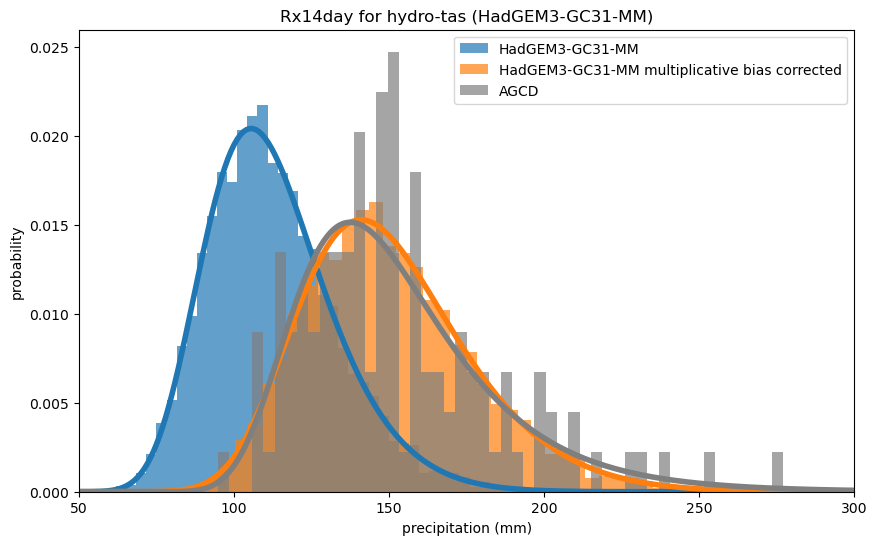

In [43]:
plot_distributions(include_multiplicative=True)

/g/data/xv83/dbi599/hydrotas/figures/Rx14day_histogram_HadGEM3-GC31-MM_hydro-tas_add_mulc.png


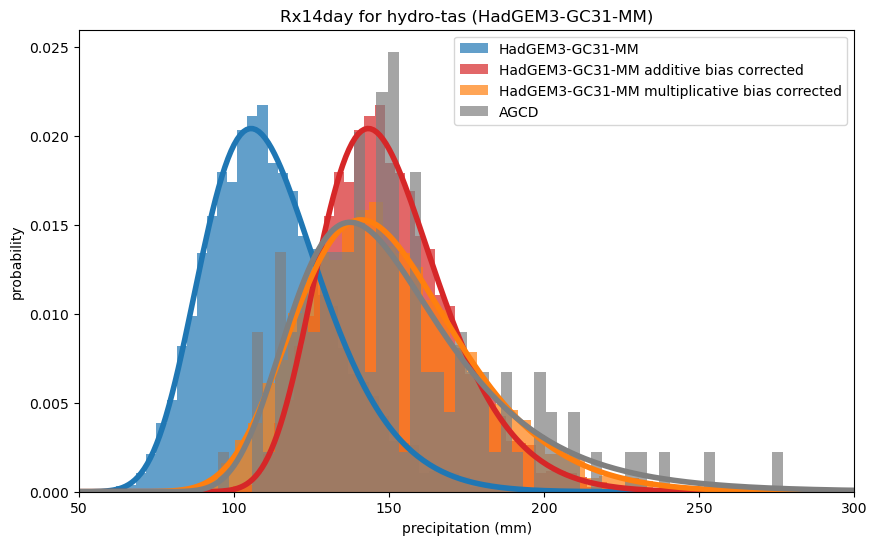

In [44]:
plot_distributions(include_multiplicative=True, include_additive=True)

In [45]:
print(f'raw data shape parameter: {model_gev_shape:.3f}')
print(f'raw data location parameter: {model_gev_loc:.3f}') 
print(f'raw data scale parameter: {model_gev_scale:.3f}')

raw data shape parameter: 0.098
raw data location parameter: 103.610
raw data scale parameter: 18.107


In [46]:
print(f'additive corrected shape parameter: {model_add_bc_gev_shape:.3f}')
print(f'additive corrected location parameter: {model_add_bc_gev_loc:.3f}') 
print(f'additive corrected scale parameter: {model_add_bc_gev_scale:.3f}')

additive corrected shape parameter: 0.098
additive corrected location parameter: 141.386
additive corrected scale parameter: 18.107


In [47]:
print(f'multiplicative corrected shape parameter: {model_mulc_bc_gev_shape:.3f}')
print(f'multiplicative corrected location parameter: {model_mulc_bc_gev_loc:.3f}') 
print(f'multiplicative corrected scale parameter: {model_mulc_bc_gev_scale:.3f}')

multiplicative corrected shape parameter: 0.098
multiplicative corrected location parameter: 138.413
multiplicative corrected scale parameter: 24.190


We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [48]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)
ks_pval_raw = float(similarity_raw_ds['ks_pval'].values)
ad_pval_raw = float(similarity_raw_ds['ad_pval'].values)
print(f'additive KS test p-value: {ks_pval_raw:.3f}')
print(f'additive AD test p-value: {ad_pval_raw:.3f}')

additive KS test p-value: 0.000
additive AD test p-value: 0.001


In [49]:
similarity_add_bias_ds = fileio.open_dataset(similarity_add_bc_file)
ks_pval_add = float(similarity_add_bias_ds['ks_pval'].values)
ad_pval_add = float(similarity_add_bias_ds['ad_pval'].values)
print(f'additive KS test p-value: {ks_pval_add:.3f}')
print(f'additive AD test p-value: {ad_pval_add:.3f}')

additive KS test p-value: 0.135
additive AD test p-value: 0.007


In [50]:
similarity_mulc_bias_ds = fileio.open_dataset(similarity_mulc_bc_file)
ks_pval_mulc = float(similarity_mulc_bias_ds['ks_pval'].values)
ad_pval_mulc = float(similarity_mulc_bias_ds['ad_pval'].values)
print(f'multiplicative KS test p-value: {ks_pval_mulc:.3f}')
print(f'multiplicative AD test p-value: {ad_pval_mulc:.3f}')

multiplicative KS test p-value: 0.561
multiplicative AD test p-value: 0.250


### Return curves

In [51]:
def gev_event_likelihood(event, shape, loc, scale):
    """Get likelihood stats for an event from a GEV fit"""

    probability = gev.sf(event, shape, loc=loc, scale=scale)
    return_period = 1. / probability
    percentile = (1 - probability) * 100
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

#### Multiplicative bias corrected data

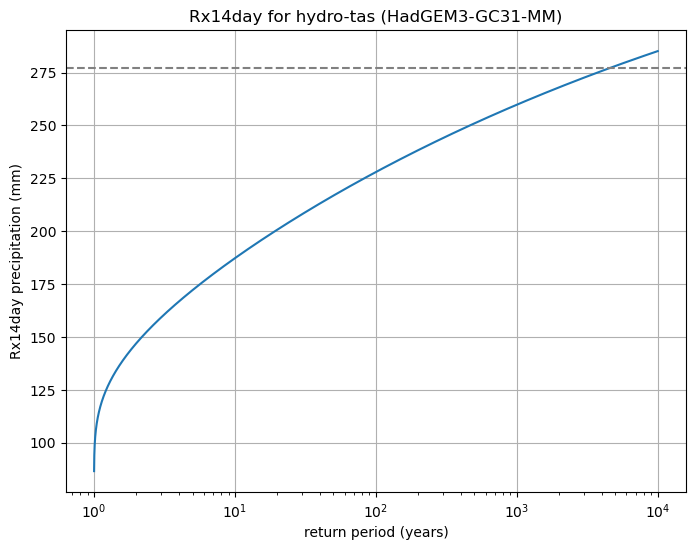

In [52]:
plot_return(model_mulc_bc_da_stacked, model_name, method='gev')

In [53]:
n_events_mulc_bc, n_population_mulc_bc, return_period_mulc_bc, percentile_mulc_bc = general_utils.event_in_context(model_add_bc_da_stacked.values, prmax, 'above')
print('MULTIPLICATIVE BIAS CORRECTED DATA')
print(f'{n_events_mulc_bc} events in {n_population_mulc_bc} samples')
print(f'{percentile_mulc_bc:.2f}% percentile')
print(f'{return_period_mulc_bc:.0f} year return period')

MULTIPLICATIVE BIAS CORRECTED DATA
0 events in 5900 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:163: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


In [54]:
print('MULTIPLICATIVE BIAS CORRECTED GEV')
for rank in range(5):
    event = float(ranked_events.iloc[[rank]]['pr'].values)
    date = ranked_events.iloc[[rank]]['event_time'].values[0]
    print(f'{date}: {event:.1f}mm')
    gev_event_likelihood(event, model_mulc_bc_gev_shape, model_mulc_bc_gev_loc, model_mulc_bc_gev_scale)

MULTIPLICATIVE BIAS CORRECTED GEV
1960-04-28: 277.1mm
99.98% percentile
4537 year return period

1923-05-24: 254.0mm
99.84% percentile
630 year return period

1947-06-24: 238.6mm
99.51% percentile
204 year return period

1929-04-14: 231.4mm
99.20% percentile
125 year return period

1958-05-29: 228.8mm
99.05% percentile
105 year return period



/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


/g/data/xv83/dbi599/hydrotas/figures/Rx14day_return_curve_gev_hydro-tas_HadGEM3-GC31-MM_by-decade_mulc.png


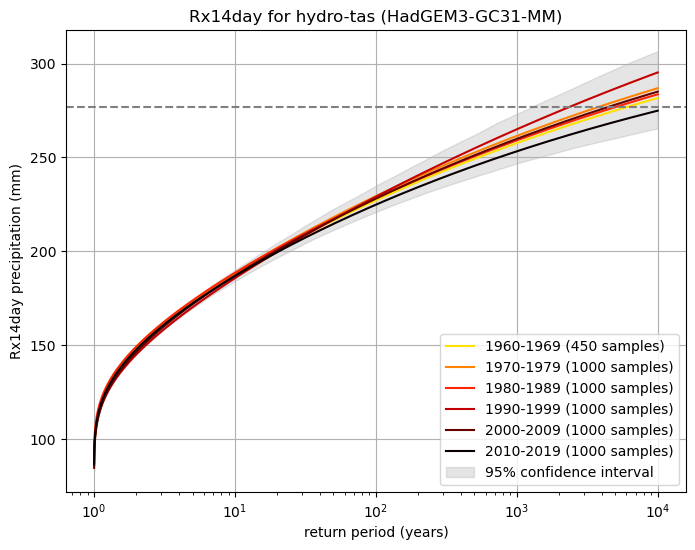

In [55]:
plot_return_by_decade(model_mulc_bc_da_stacked, model_name, method='gev', uncertainty=True, savefig='mulc')

### Seasonality

In [56]:
model_df = model_da_stacked.to_dataframe()
model_df = model_df.dropna()

In [57]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

In [58]:
model_df['month'] = event_months
monthly_ave = model_df.groupby('month').mean(['pr'])

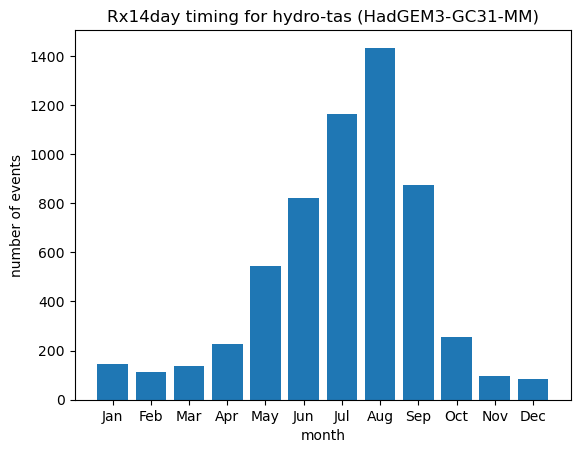

In [59]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx14day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

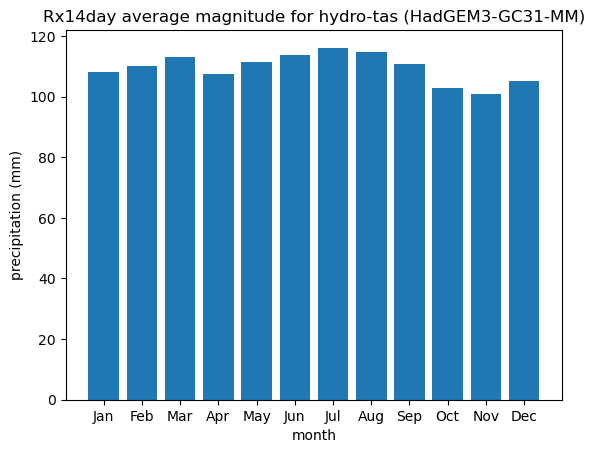

In [60]:
months = np.arange(1, 13)
averages = monthly_ave['pr'].values

plt.bar(months, averages)
plt.title(f'Rx14day average magnitude for {region_name} ({model_name})')
plt.ylabel('precipitation (mm)')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
plt.show()

### Relationship with ENSO

In [61]:
nino_ds = fileio.open_dataset(nino_file)
nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
nino_ds

<xarray.Dataset>
Dimensions:    (init_date: 59, ensemble: 10, lead_time: 125)
Coordinates:
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 118 119 120 121 122 123 124
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8 9
  * init_date  (init_date) <U6 '196011' '196111' '196211' ... '201711' '201811'
    time       (lead_time, init_date) object dask.array<chunksize=(125, 59), meta=np.ndarray>
Data variables:
    tos        (init_date, ensemble, lead_time) float32 dask.array<chunksize=(59, 10, 125), meta=np.ndarray>
Attributes:
    history:  Thu Apr 06 11:16:45 2023: /g/data/xv83/dbi599/miniconda3/envs/u...

In [62]:
nino_values = []
for index, row in model_df.iterrows():
    event_init_date = row['init_date'].strftime('%Y%m')
    event_ensemble = row['ensemble']
    event_year_month = row['time'].strftime('%Y-%m')
    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
    nino_values.append(nino_value)

In [63]:
model_df['nino34'] = nino_values

/g/data/xv83/dbi599/miniconda3/envs/unseen2/lib/python3.10/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


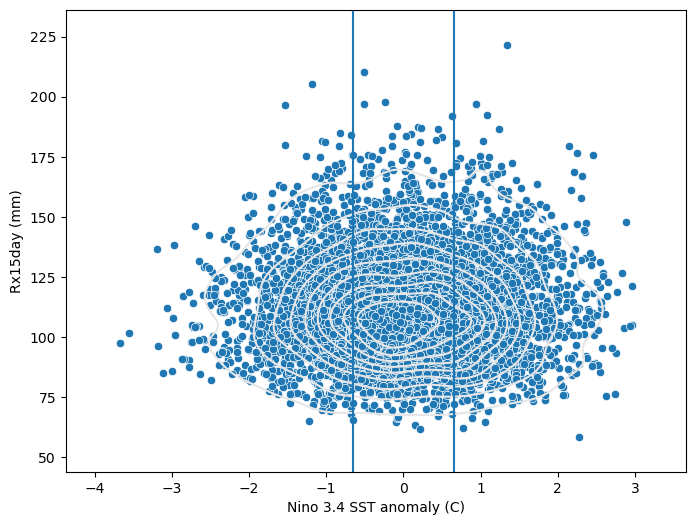

In [64]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)

ax.set_ylabel('Rx15day (mm)')
ax.set_xlabel('Nino 3.4 SST anomaly (C)')
ax.axvline(0.65)
ax.axvline(-0.65)
plt.show()

### Meteorology

In [65]:
def plot_average(start_date, end_date, color_da=None, color_var=None, contour_da=None, contour_var=None):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var:
        if color_var == 'pr':
            levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
            label = 'total precipitation (mm)'
            cmap = cmocean.cm.rain
            extend = 'max'
        elif color_var == 'ua300':
            levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
            label = '300hPa zonal wind'
            cmap='RdBu_r'
            extend = 'both'
        else:
            raise ValueError('Invalid color variable')
        color_da.plot(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            levels=levels,
            extend=extend,
            cbar_kwargs={'label': label},
        )
    
    if contour_var:
        if contour_var == 'z500':
            levels = np.arange(5000, 6300, 50)
        elif contour_var == 'psl':
            levels = np.arange(900, 1100, 2.5)
        elif contour_var == 'ua300':
            levels = np.arange(15, 60, 5)
        else:
            raise ValueError('Invalid contour variable')
        lines = contour_da.plot.contour(
            ax=ax1,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    if contour_var:
        ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    else:
        ax1.set_title(f'{start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [66]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

event_time                 time  \
ensemble init_date           lead_time                                    
1        1970-11-01 00:00:00 3          1973-05-27  1973-11-01 12:00:00   
4        1984-11-01 00:00:00 6          1990-08-07  1990-11-01 12:00:00   
         1978-11-01 00:00:00 2          1980-07-06  1980-11-01 12:00:00   
9        1974-11-01 00:00:00 8          1982-06-07  1982-11-01 12:00:00   
0        1993-11-01 00:00:00 9          2002-08-17  2002-11-01 12:00:00   
3        1993-11-01 00:00:00 10         2003-09-09  2003-11-01 12:00:00   
0        2003-11-01 00:00:00 5          2008-07-21  2008-11-01 12:00:00   
7        1990-11-01 00:00:00 10         2000-03-16  2000-11-01 12:00:00   
1        1977-11-01 00:00:00 7          1984-09-24  1984-11-01 12:00:00   
4        1992-11-01 00:00:00 5          1997-05-28  1997-11-01 12:00:00   

                                        ensemble            init_date  \
ensemble init_date           lead_time                                  
1        1970-11-01 00:00:00 3                 1  1970-11-01 00:00:00   
4        1984-11-01 00:00:00 6                 4  1984-11-01 00:00:00   
         1978-11-01 00:00:00 2                 4  1978-11-01 00:00:00   
9        1974-11-01 00:00:00 8                 9  1974-11-01 00:00:00   
0        1993-11-01 00:00:00 9                 0  1993-11-01 00:00:00   
3        1993-11-01 00:00:00 10                3  1993-11-01 00:00:00   
0        2003-11-01 00:00:00 5                 0  2003-11-01 00:00:00   
7        1990-11-01 00:00:00 10                7  1990-11-01 00:00:00   
1        1977-11-01 00:00:00 7                 1  1977-11-01 00:00:00   
4        1992-11-01 00:00:00 5                 4  1992-11-01 00:00:00   

                                        lead_time          pr  month    nino34  
ensemble init_date           lead_time                                          
1        1970-11-01 00:00:00 3                  3  221.520998      5  1.341261  
4        1984-11-01 00:00:00 6                  6  210.121189      8 -0.509933  
         1978-11-01 00:00:00 2                  2  205.088502      7 -1.189730  
9        1974-11-01 00:00:00 8                  8  197.919581      6 -0.232960  
0        1993-11-01 00:00:00 9                  9  196.937486      8  0.945860  
3        1993-11-01 00:00:00 10                10  196.879683      9 -0.507000  
0        2003-11-01 00:00:00 5                  5  196.594591      7 -1.530264  
7        1990-11-01 00:00:00 10                10  192.187951      3  1.088049  
1        1977-11-01 00:00:00 7                  7  191.947217      9  0.628212  
4        1992-11-01 00:00:00 5                  5  187.695127      5 -0.087574

In [67]:
model_add_bc_df = model_add_bc_ds['pr'].to_dataframe()
model_add_bc_df = model_add_bc_df.dropna()
model_add_bc_df = model_add_bc_df.reset_index()
ranked_add_bc_events = model_add_bc_df.sort_values(by=['pr'], ascending=False)
ranked_add_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
1012,1970-11-01 00:00:00,1,3,1973-05-27,1973-11-01 12:00:00,259.296867
2445,1984-11-01 00:00:00,4,6,1990-08-07,1990-11-01 12:00:00,247.897058
1841,1978-11-01 00:00:00,4,2,1980-07-06,1980-11-01 12:00:00,242.864371
1497,1974-11-01 00:00:00,9,8,1982-06-07,1982-11-01 12:00:00,235.695451
3308,1993-11-01 00:00:00,0,9,2002-08-17,2002-11-01 12:00:00,234.713356
3339,1993-11-01 00:00:00,3,10,2003-09-09,2003-11-01 12:00:00,234.655552
4304,2003-11-01 00:00:00,0,5,2008-07-21,2008-11-01 12:00:00,234.370460
3079,1990-11-01 00:00:00,7,10,2000-03-16,2000-11-01 12:00:00,229.963820
1716,1977-11-01 00:00:00,1,7,1984-09-24,1984-11-01 12:00:00,229.723086
3244,1992-11-01 00:00:00,4,5,1997-05-28,1997-11-01 12:00:00,225.470997


In [68]:
model_mulc_bc_df = model_mulc_bc_ds['pr'].to_dataframe()
model_mulc_bc_df = model_mulc_bc_df.dropna()
model_mulc_bc_df = model_mulc_bc_df.reset_index()
ranked_mulc_bc_events = model_mulc_bc_df.sort_values(by=['pr'], ascending=False)
ranked_mulc_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
1012,1970-11-01 00:00:00,1,3,1973-05-27,1973-11-01 12:00:00,295.931671
2445,1984-11-01 00:00:00,4,6,1990-08-07,1990-11-01 12:00:00,280.702575
1841,1978-11-01 00:00:00,4,2,1980-07-06,1980-11-01 12:00:00,273.979368
1497,1974-11-01 00:00:00,9,8,1982-06-07,1982-11-01 12:00:00,264.402350
3308,1993-11-01 00:00:00,0,9,2002-08-17,2002-11-01 12:00:00,263.090362
3339,1993-11-01 00:00:00,3,10,2003-09-09,2003-11-01 12:00:00,263.013141
4304,2003-11-01 00:00:00,0,5,2008-07-21,2008-11-01 12:00:00,262.632284
3079,1990-11-01 00:00:00,7,10,2000-03-16,2000-11-01 12:00:00,256.745419
1716,1977-11-01 00:00:00,1,7,1984-09-24,1984-11-01 12:00:00,256.423821
3244,1992-11-01 00:00:00,4,5,1997-05-28,1997-11-01 12:00:00,250.743420


1970 (1973-05-27), ensemble: r2, 221.52099789091363mm


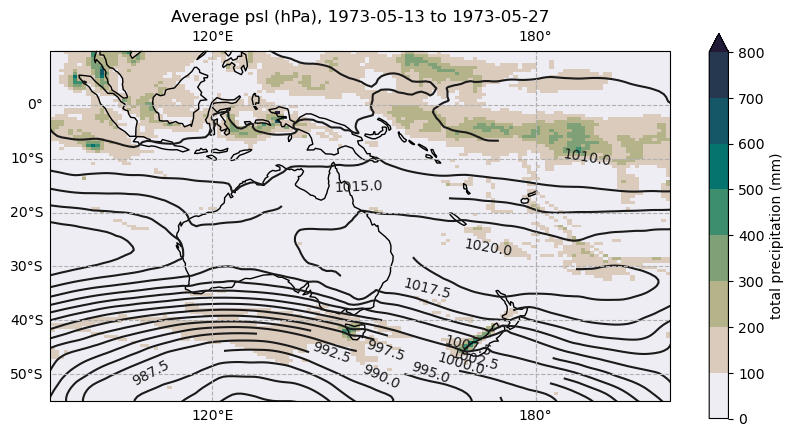

1984 (1990-08-07), ensemble: r5, 210.1211886606548mm


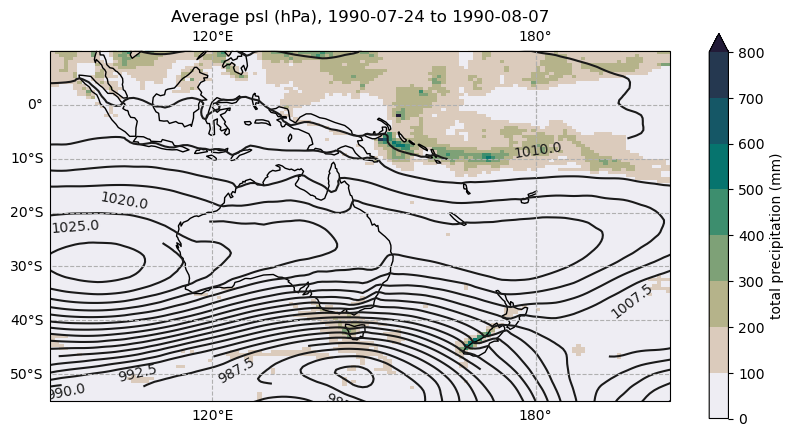

1978 (1980-07-06), ensemble: r5, 205.08850186082296mm


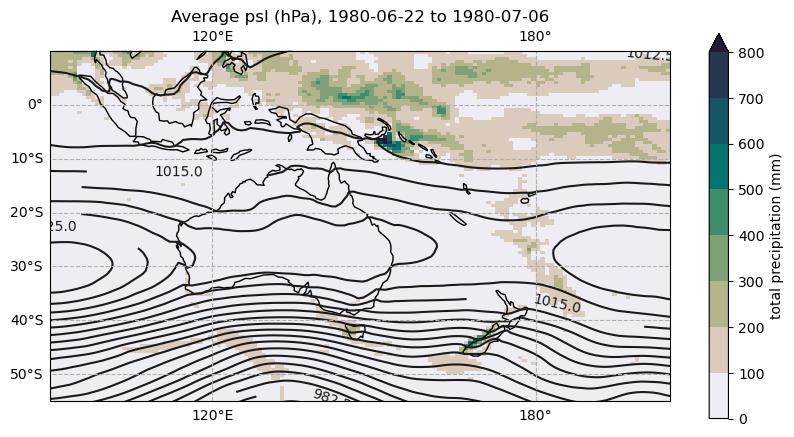

1974 (1982-06-07), ensemble: r10, 197.91958119595918mm


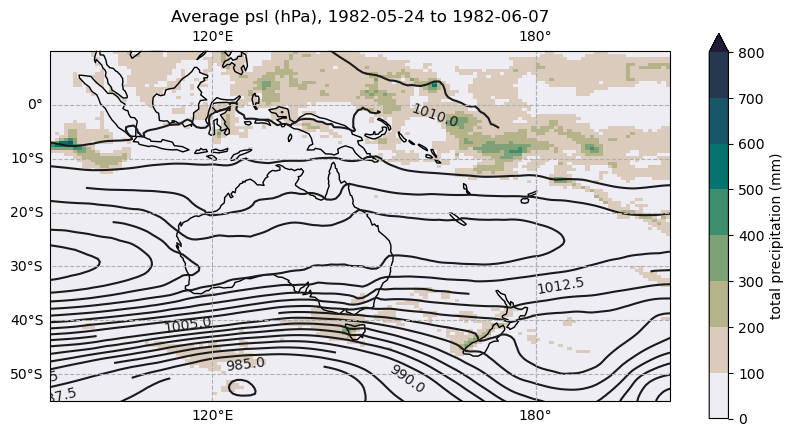

In [69]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = int(row['init_date'].strftime('%Y'))
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble: r{ensemble}, {rx_value}mm')
    
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    
    pr_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f2/day/pr/*/*/*.nc')
    pr_files.sort()
    ds_pr = fileio.open_dataset(pr_files, variables=['pr'],)
    
    psl_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f2/day/psl/*/*/*.nc')
    psl_files.sort()
    ds_psl = fileio.open_dataset(psl_files, variables=['psl'],)
    
#    zg_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/zg/*/*/*.nc')
#    zg_files.sort()
#    ds_zg = fileio.open_dataset(zg_files, variables=['zg'],)
    
#    ua_files = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/*/{model_name}/dcppA-hindcast/s{init_date}-r{ensemble}i1p1f1/day/ua/*/*/*.nc')
#    ua_files.sort()
#    ds_ua = fileio.open_dataset(ua_files, variables=['ua'],)

    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')
#    zg_da = ds_zg.sel({'time': slice(start_date, end_date)})['zg']
#    z500_da = zg_da.sel({'plev': 50000}, method='nearest')
#    ua_da = ds_ua.sel({'time': slice(start_date, end_date)})['ua']
#    ua300_da = ua_da.sel({'plev': 30000}, method='nearest')

    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
#    z500_da_mean = z500_da.mean('time', keep_attrs=True)
#    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(start_date, end_date, pr_da_sum, 'pr', psl_da_mean, 'psl')
#    plot_average(start_date, end_date, pr_da_sum, 'pr', z500_da_mean, 'z500')
#    plot_average(start_date, end_date, ua300_da_mean, 'ua300', z500_da_mean, 'z500')